## configuration instead of code

This notebook will develop some ideas about a configuration system to describe models in a simple format that encourages exchange between users and long term usability.  Many concepts are derived from conventions in the Thinc library, and we want to take a compositional approach: if the built in simulator loop isn't approach, use config components just for the model building to save time.  Some use cases to keep in mind, but not all implement at once

- field models (R^3 & S^2)
- multiple possibly high res connectomes
- flexible stimulation (not just TVB-style)
- mixed subcortical cortical models e.g. JR here, MPR there, etc
- library of reusable components
- flexible full model spec + debugging tools
- multiscale / cosim

We start by assuming the target model usage can be described roughly as a tree, e.g. 

- exec
  - number of cores
  - data source
  - sbatch array / daskiness
  - etc
- data
  - connectivity
  - surface
  - subcortical volumes
  - time series
      - preprocessing e.g. FFT or FCD
- model
  - integration scheme
  - global DE
    - coupling/connectivity components
    - aux equations
    - DE RHSs in sympy-digestible form
        - could be grouped e.g. JR w/ a spatial mask
  - forward models ("monitors")
    - e.g. BOLD has it's own equations & integrator
  - postprocessing e.g. FFT or FCD, to match data preprocessing
- stats/fit
  - parameter & prior combinations
  - inference method (map, vi, nuts) + config
  - post processing / diagnostics

In the following we'll try to prototype this with [confection](https://github.com/explosion/confection) for the neural field inference developed in [a sibling notebook](60%20First%20field%20in%20numpyro.ipynb), taking advantage of the function registry to check types and avoid as much ad-hoc code as possible.  As it develops, we push code into the Python library.  It may be useful to use Pydantic for sanity checking, cf [this write up](https://medium.com/swlh/cool-things-you-can-do-with-pydantic-fc1c948fbde0).

## getting started

First off we define a registry,

In [1]:
%pylab inline
import numpy as np
import numpy.typing as npt
import functools
import catalogue
from confection import registry, Config

registry.legos = catalogue.create("confection", "legos", entry_points=False)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


To debug registered function calls, we'll set up our own decorator for registration,

In [2]:
def new_lego(name=None):
    def wrapper(wrapped):
        @registry.legos.register(name or wrapped.__name__)
        @functools.wraps(wrapped)
        def f(*args, **kwargs):
            print(f'invoking {wrapped}')
            return wrapped(*args, **kwargs)
        return f
    return wrapper

with that bit of bureaucracy we can do the following,

In [3]:
@new_lego()
def make_shtdiff(lmax: int, nlat: int, nlon: int, D: float=0.0004) -> np.ndarray[np.float32]:
    """Computes a precomputed spherical harmonic transform-based diffusion
    coupling function.
    
    Parameters
    ----------
    lmax
        Truncation order for the spherical harmonic series, `lmax` < `nlat`.
    nlat
        Number of latitudes for the regular spherical grid.
    nlon
        Number of longitudes for the regular spherical grid.
    D
        Scaling of the diffusion, default value of `4e-4` based on r=10 cm
        inflated cortical surface.
    
    Returns
    -------
    L
        A 3-D array where each `L[m]` matrix provides the Legendre transform
        for the `m`th longitudinal frequency
    
    """
    import nfjax.shtlc as lc
    if lmax >= nlat:
        lmax = nlat - 1
    _, L = lc.make_shtdiff(lmax=lmax, nlat=nlat, nlon=nlon, D=D, return_L=True)
    np.testing.assert_equal(0, L.imag)
    L = L.real.astype('f')
    return L

@new_lego()
def randn_init(nlat: int, nlon: int) -> np.ndarray[np.float32]:
    "Generate random initial state."
    return np.random.randn(nlat, nlon)

@new_lego()
def apply_shtdiff(L: np.ndarray[np.float32], x: np.ndarray[np.complex64]) -> np.ndarray[np.complex64]:
    """Computes the spherical harmonic transform using precomputed Legendre transforms.
    
    
    """
    lmax = L.shape[0]
    X = np.fft.rfft(x, axis=1)
    X = np.hstack(
        (np.einsum('abc,ca->ba', L, X[:,:lmax]),
         np.zeros((X.shape[0], X.shape[1] - lmax), np.complex64)
        )
    )
    y = np.real(np.fft.irfft(X, axis=1))
    return y

These functions provide a Python API usable from regular code but since they are registered, they can be invoked via the configuration system,

invoking <function make_shtdiff at 0x11b4ef7f0>
invoking <function randn_init at 0x11b4ef640>
invoking <function make_shtdiff at 0x11b4ef7f0>
invoking <function randn_init at 0x11b4ef640>
invoking <function apply_shtdiff at 0x11b4ef910>


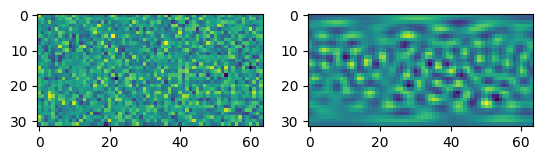

In [4]:
res = registry.resolve(Config().from_str('''
[lc]
@legos = make_shtdiff
lmax = 17
nlat = 32
nlon = 64

[x0]
@legos = randn_init
nlat = ${lc.nlat}
nlon = ${lc.nlon}

[x1]
@legos = apply_shtdiff
L = ${lc}
x = ${x0}
'''))

subplot(121); imshow(res['x0'])
subplot(122); imshow(res['x1'])

From this we see a few things

- no code to write to map parsed config to functions
- data flow is defined using back references to other config sections
- back refs allow not repeating details like `nlat`

*To be continued through building simulation object and doing inference.*